In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
install.packages("igraph")
library(igraph)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




Total number of edges:  121771 


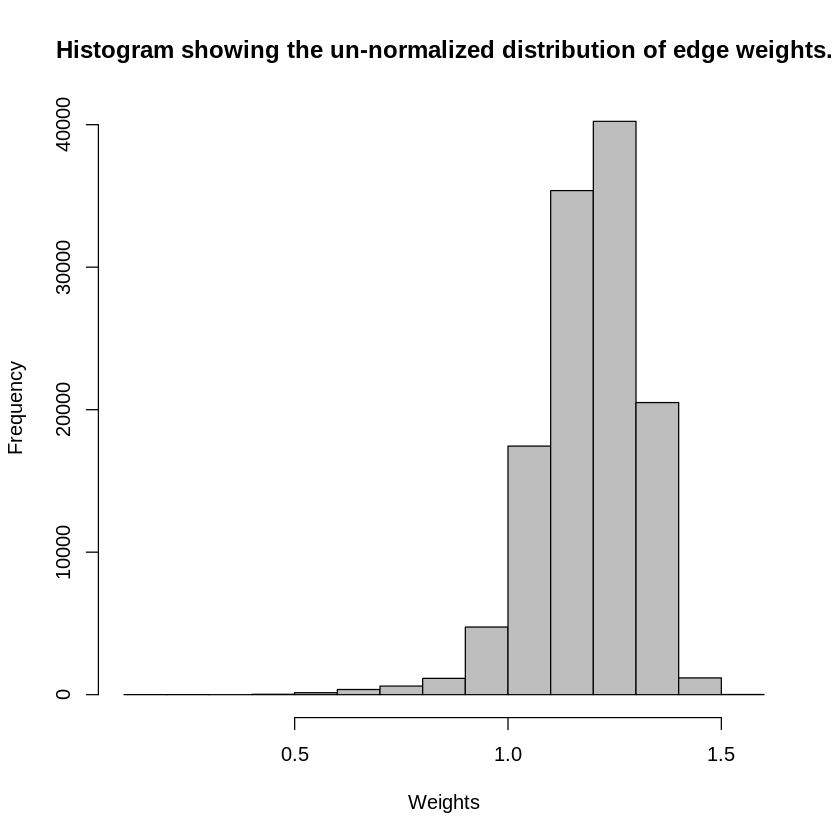

In [2]:
#Q2
data_path <- "/content/drive/MyDrive/Colab Notebooks/finance_data/data"
sector_path <- "/content/drive/MyDrive/Colab Notebooks/finance_data/Name_sector.csv"


tickers_sectors <- read.csv(sector_path, header = TRUE)
files <- list.files(data_path, pattern = "\\.csv$", full.names = TRUE)

length_data <- c()
i <- 1
valid_tickers <- c()
log_norm_mat <- matrix(0, nrow = length(files), ncol = 764)

for (j in seq_along(files)) {
  df <- read.csv(files[j])
  length_data[j] <- nrow(df)
  if (length_data[j] == 765) {
    p <- df[, 5]
    q <- diff(p) / head(p, -1)
    r <- log(1 + q)
    log_norm_mat[i, ] <- r
    valid_tickers <- c(valid_tickers, tools::file_path_sans_ext(basename(files[j])))
    i <- i + 1
  }
}


log_norm_mat <- log_norm_mat[1:(i - 1), ]
tickers_sectors <- tickers_sectors[length_data == 765, ]
tickers_sectors <- tickers_sectors[1:(i - 1), ]


edge_list <- data.frame(Source = character(),
                        Sink = character(),
                        Weight = numeric(),
                        stringsAsFactors = FALSE)

for (i in 1:(nrow(log_norm_mat) - 1)) {
  for (j in (i + 1):nrow(log_norm_mat)) {
    ri_mean <- mean(log_norm_mat[i, ])
    rj_mean <- mean(log_norm_mat[j, ])
    numerator <- mean(log_norm_mat[i, ] * log_norm_mat[j, ]) - ri_mean * rj_mean
    denominator <- sqrt(
      (mean(log_norm_mat[i, ]^2) - ri_mean^2) *
      (mean(log_norm_mat[j, ]^2) - rj_mean^2)
    )
    rho_ij <- numerator / denominator
    w_ij <- sqrt(2 * (1 - rho_ij))

    edge_list <- rbind(edge_list, data.frame(
      Source = tickers_sectors[i, 1],
      Sink = tickers_sectors[j, 1],
      Weight = w_ij
    ))
  }
}


correlation_graph <- graph_from_data_frame(edge_list, directed = FALSE)
E(correlation_graph)$weight <- edge_list$Weight


hist(edge_list$Weight,
     breaks = 10,
     col = "gray",
     main = "Histogram showing the un-normalized distribution of edge weights.",
     xlab = "Weights",
     ylab = "Frequency")



cat("Total number of edges: ", nrow(edge_list), "\n")


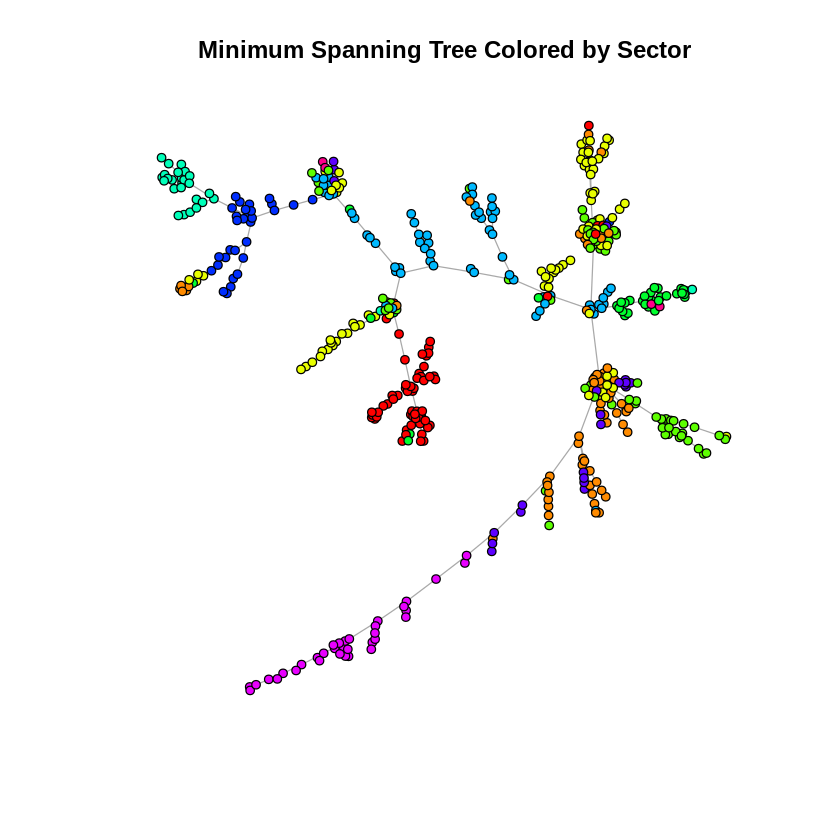

In [3]:
#Q3

mst_graph <- mst(correlation_graph, algorithm = "prim")

sectors <- unique(tickers_sectors[, 2])
sector_colors <- rainbow(length(sectors))

sector_color_map <- setNames(sector_colors, sectors)

node_colors <- sapply(tickers_sectors[, 2], function(sec) sector_color_map[sec])

plot(
  mst_graph,
  vertex.size = 3,
  vertex.label = NA,
  vertex.color = node_colors,
  main = "Minimum Spanning Tree Colored by Sector"
)



In [4]:
install.packages("aricode")
library(aricode)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘BH’




Homogeneity: 0.6826
Completeness: 0.4793


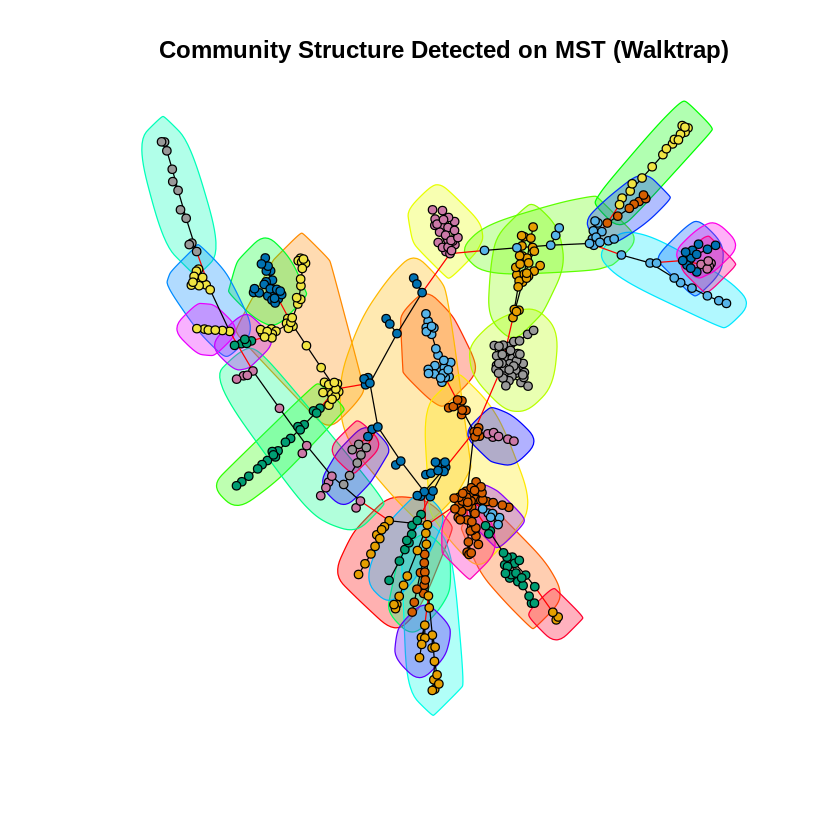

In [6]:
# Q4
walktrap_comm <- cluster_walktrap(mst_graph, weights = E(mst_graph)$weight)
membership_vec <- membership(walktrap_comm)

community_labels <- membership_vec
sector_labels <- tickers_sectors[, 2]

label_df <- data.frame(
  community = as.factor(community_labels),
  sector = as.factor(sector_labels)
)

install.packages("clevr")

library(clevr)

homogeneity_score <- homogeneity(label_df$sector, label_df$community)
completeness_score <- completeness(label_df$sector, label_df$community)

cat(sprintf("Homogeneity: %.4f\n", homogeneity_score))
cat(sprintf("Completeness: %.4f\n", completeness_score))

plot(
  walktrap_comm,
  mst_graph,
  vertex.color = membership_vec,
  vertex.label = NA,
  vertex.size = 3,
  main = "Community Structure Detected on MST (Walktrap)"
)


In [7]:
# Q5
sectors <- tickers_sectors[, 2]
unique_sectors <- unique(sectors)
sector_sizes <- table(sectors)
V_total <- vcount(mst_graph)

P_same_sector <- numeric(V_total)
P_random_baseline <- numeric(V_total)

for (v in 1:V_total) {
  neighbors_v <- neighbors(mst_graph, v)
  if (length(neighbors_v) == 0) {
    P_same_sector[v] <- NA
    P_random_baseline[v] <- NA
    next
  }

  sector_v <- sectors[v]
  same_sector_count <- sum(sectors[neighbors_v] == sector_v)
  P_same_sector[v] <- same_sector_count / length(neighbors_v)

  P_random_baseline[v] <- sector_sizes[sector_v] / V_total
}

alpha_score <- mean(P_same_sector, na.rm = TRUE)
alpha_baseline <- mean(P_random_baseline, na.rm = TRUE)

cat(sprintf("α (neighbor voting accuracy): %.4f\n", alpha_score))
cat(sprintf("baseline (random guess):     %.4f\n", alpha_baseline))


α (neighbor voting accuracy): 0.8289
baseline (random guess):     0.1142


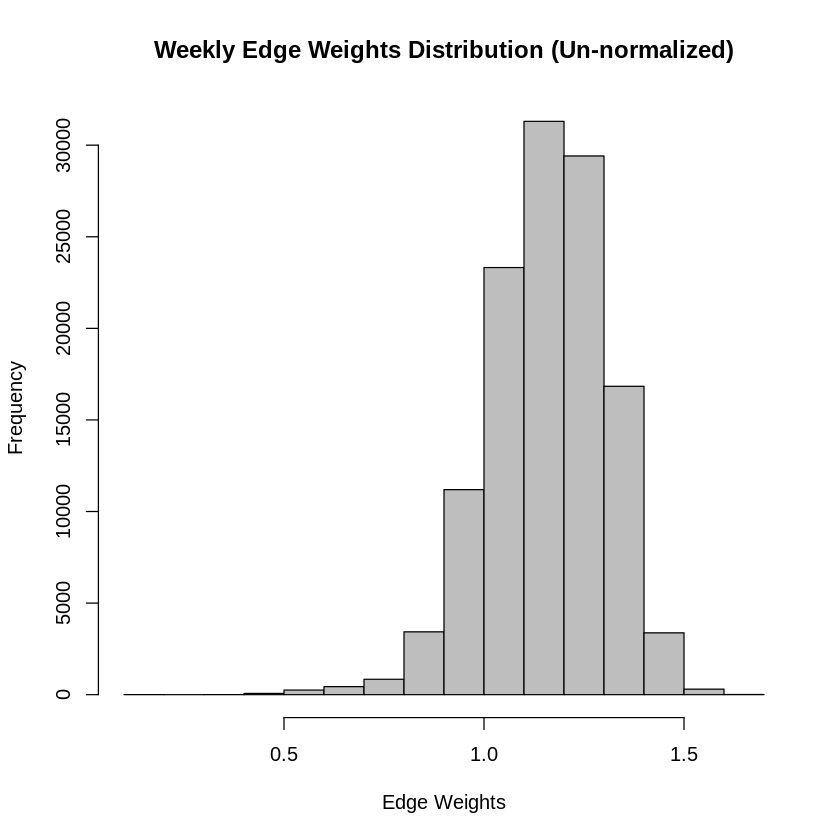

In [8]:
# Q6

data_path <- "/content/drive/MyDrive/Colab Notebooks/finance_data/data"
sector_path <- "/content/drive/MyDrive/Colab Notebooks/finance_data/Name_sector.csv"

files <- list.files(data_path, pattern = "\\.csv$", full.names = TRUE)
sectors_df <- read.csv(sector_path, stringsAsFactors = FALSE)

weekly_returns <- list()
valid_index <- c()
stock_names <- c()

for (i in seq_along(files)) {
  df <- read.csv(files[i])
  df$Date <- as.Date(df[, 1])
  df$Weekday <- weekdays(df$Date)

  df_mon <- df[df$Weekday == "Monday", ]

  if (nrow(df_mon) == 143) {
    prices <- df_mon[, 5]
    log_ret <- log(1 + diff(prices) / head(prices, -1))
    weekly_returns[[length(weekly_returns) + 1]] <- log_ret
    valid_index <- c(valid_index, i)
    stock_names <- c(stock_names, tools::file_path_sans_ext(basename(files[i])))
  }
}

log_norm_mat_week <- do.call(rbind, weekly_returns)
colnames(log_norm_mat_week) <- paste0("Week_", 1:ncol(log_norm_mat_week))

sector_filtered <- sectors_df[valid_index, ]
rownames(log_norm_mat_week) <- stock_names

edge_list_week <- data.frame(Source = character(),
                             Target = character(),
                             Weight = numeric(),
                             stringsAsFactors = FALSE)

n <- nrow(log_norm_mat_week)
for (i in 1:(n - 1)) {
  for (j in (i + 1):n) {
    rho_ij <- cor(log_norm_mat_week[i, ], log_norm_mat_week[j, ])
    dist_ij <- sqrt(2 * (1 - rho_ij))
    edge_list_week <- rbind(edge_list_week, data.frame(
      Source = stock_names[i],
      Target = stock_names[j],
      Weight = dist_ij
    ))
  }
}

hist(edge_list_week$Weight,
     col = "gray",
     main = "Weekly Edge Weights Distribution (Un-normalized)",
     xlab = "Edge Weights",
     ylab = "Frequency")


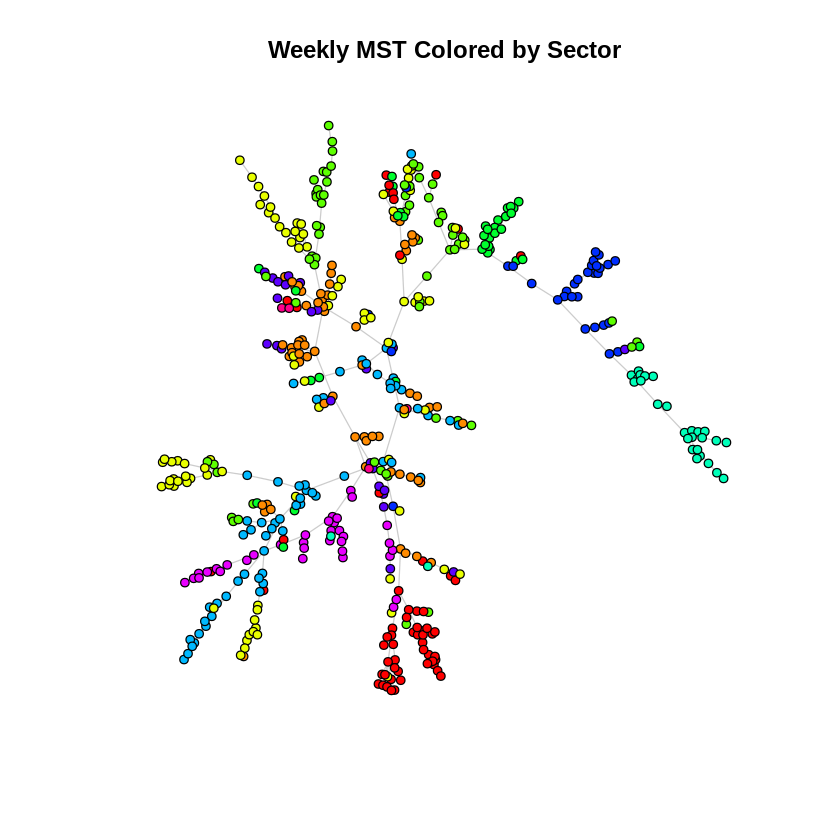

In [9]:
# Q6 - Q3
cg_weekly <- graph_from_data_frame(edge_list_week, directed = FALSE)
E(cg_weekly)$weight <- edge_list_week$Weight

mst_weekly <- mst(cg_weekly, algorithm = "prim")

sectors <- sector_filtered[, 2]
unique_sectors <- unique(sectors)
sector_palette <- rainbow(length(unique_sectors))
sector_color_map <- setNames(sector_palette, unique_sectors)
node_colors <- sapply(sectors, function(sec) sector_color_map[sec])

layout_mst <- layout_with_fr(mst_weekly)

plot(mst_weekly,
     layout = layout_mst,
     vertex.color = node_colors,
     vertex.size = 3,
     vertex.label = NA,
     edge.color = "gray80",
     main = "Weekly MST Colored by Sector")


Weekly Homogeneity: 0.5811
Weekly Completeness: 0.3900


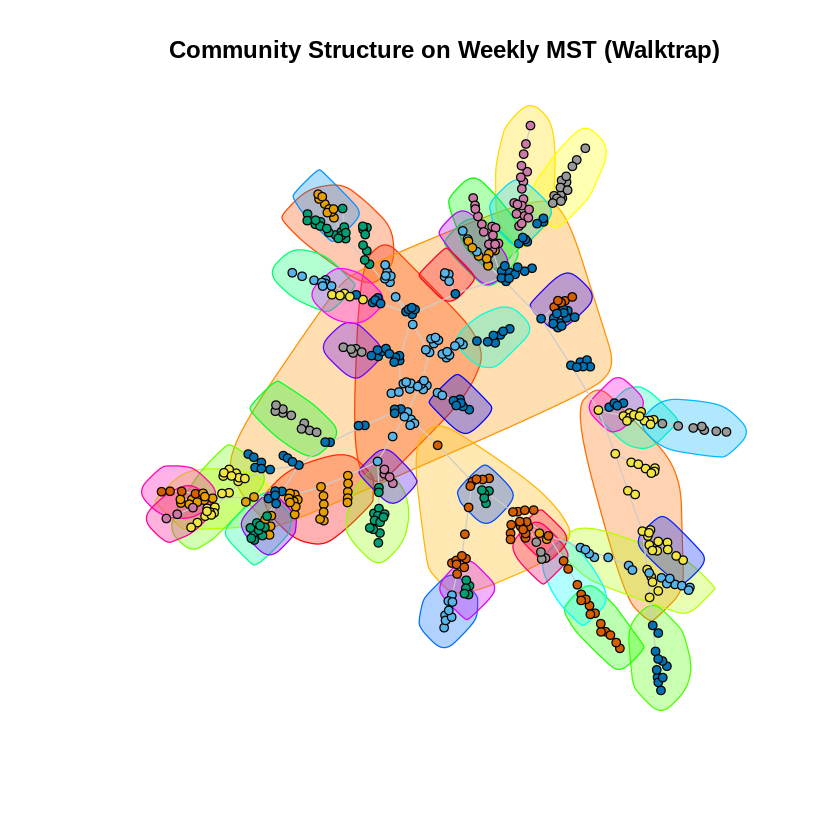

In [10]:
# Q6 - Q4
library(clevr)

walktrap_weekly <- cluster_walktrap(mst_weekly, weights = E(mst_weekly)$weight)
membership_vec <- membership(walktrap_weekly)

label_df_week <- data.frame(
  sector = as.factor(sector_filtered[, 2]),
  community = as.factor(membership_vec)
)

homog_w <- homogeneity(label_df_week$sector, label_df_week$community)
compl_w <- completeness(label_df_week$sector, label_df_week$community)

cat(sprintf("Weekly Homogeneity: %.4f\n", homog_w))
cat(sprintf("Weekly Completeness: %.4f\n", compl_w))

plot(walktrap_weekly, mst_weekly,
     vertex.size = 3,
     vertex.label = NA,
     vertex.color = membership_vec,
     edge.color = "gray80",
     main = "Community Structure on Weekly MST (Walktrap)")


In [11]:
# Q6 - Q5

sectors_week <- sector_filtered[, 2]
unique_sectors_week <- unique(sectors_week)
sector_sizes_week <- table(sectors_week)
V_week <- vcount(mst_weekly)

P_same_sector_week <- numeric(V_week)
P_random_baseline_week <- numeric(V_week)

for (v in 1:V_week) {
  neighbors_v <- neighbors(mst_weekly, v)
  if (length(neighbors_v) == 0) {
    P_same_sector_week[v] <- NA
    P_random_baseline_week[v] <- NA
    next
  }

  sector_v <- sectors_week[v]
  same_sector_count <- sum(sectors_week[neighbors_v] == sector_v)
  P_same_sector_week[v] <- same_sector_count / length(neighbors_v)
  P_random_baseline_week[v] <- sector_sizes_week[sector_v] / V_week
}

alpha_week <- mean(P_same_sector_week, na.rm = TRUE)
baseline_week <- mean(P_random_baseline_week, na.rm = TRUE)

cat(sprintf("α (neighbor voting accuracy, weekly): %.4f\n", alpha_week))
cat(sprintf("baseline (random guess, weekly):     %.4f\n", baseline_week))


α (neighbor voting accuracy, weekly): 0.7440
baseline (random guess, weekly):     0.1143


In [12]:
#Q7
data_path <- "/content/drive/MyDrive/Colab Notebooks/finance_data/data"
sector_path <- "/content/drive/MyDrive/Colab Notebooks/finance_data/Name_sector.csv"

file_paths <- list.files(data_path, pattern = "\\.csv$", full.names = TRUE)
sector_df <- read.csv(sector_path, stringsAsFactors = FALSE)

monthly_returns <- list()
valid_indices <- c()
stock_names <- c()

for (i in seq_along(file_paths)) {
  df <- read.csv(file_paths[i], stringsAsFactors = FALSE)
  df$Date <- as.Date(df[, 1])
  df <- df[format(df$Date, "%d") == "15", ]

  if (nrow(df) == 25) {
    prices <- df[, 5]
    log_ret <- log(1 + diff(prices) / head(prices, -1))
    monthly_returns[[length(monthly_returns) + 1]] <- log_ret
    valid_indices <- c(valid_indices, i)
    stock_names <- c(stock_names, tools::file_path_sans_ext(basename(file_paths[i])))
  }
}


log_norm_mat_month <- do.call(rbind, monthly_returns)
colnames(log_norm_mat_month) <- paste0("Month_", 1:ncol(log_norm_mat_month))
rownames(log_norm_mat_month) <- stock_names

sector_filtered_month <- sector_df[valid_indices, ]

Total number of edges in monthly graph: 120786 


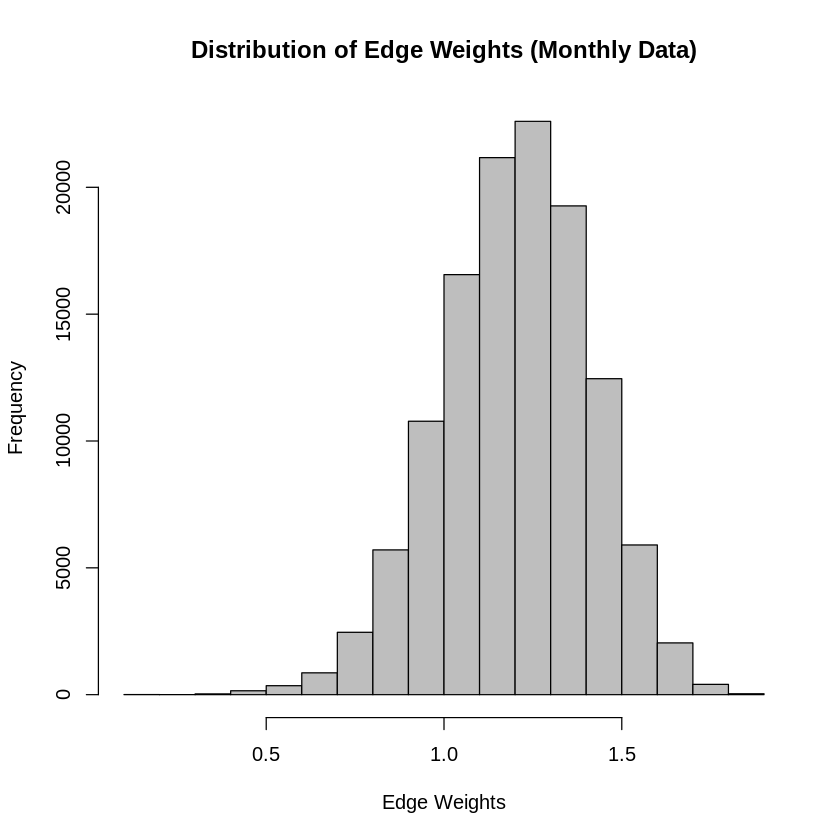

In [13]:
# Q7 - Q2
n_month <- nrow(log_norm_mat_month)
edge_list_month <- data.frame(Source = character(),
                              Sink = character(),
                              Weight = numeric(),
                              stringsAsFactors = FALSE)


for (i in 1:(n_month - 1)) {
  for (j in (i + 1):n_month) {
    ri <- log_norm_mat_month[i, ]
    rj <- log_norm_mat_month[j, ]

    rho_ij <- cor(ri, rj)
    weight <- sqrt(2 * (1 - rho_ij))

    edge_list_month <- rbind(edge_list_month, data.frame(
      Source = rownames(log_norm_mat_month)[i],
      Sink = rownames(log_norm_mat_month)[j],
      Weight = weight
    ))
  }
}




hist(edge_list_month$Weight,
     col = "gray",
     main = "Distribution of Edge Weights (Monthly Data)",
     xlab = "Edge Weights",
     ylab = "Frequency")


cat("Total number of edges in monthly graph:", nrow(edge_list_month), "\n")


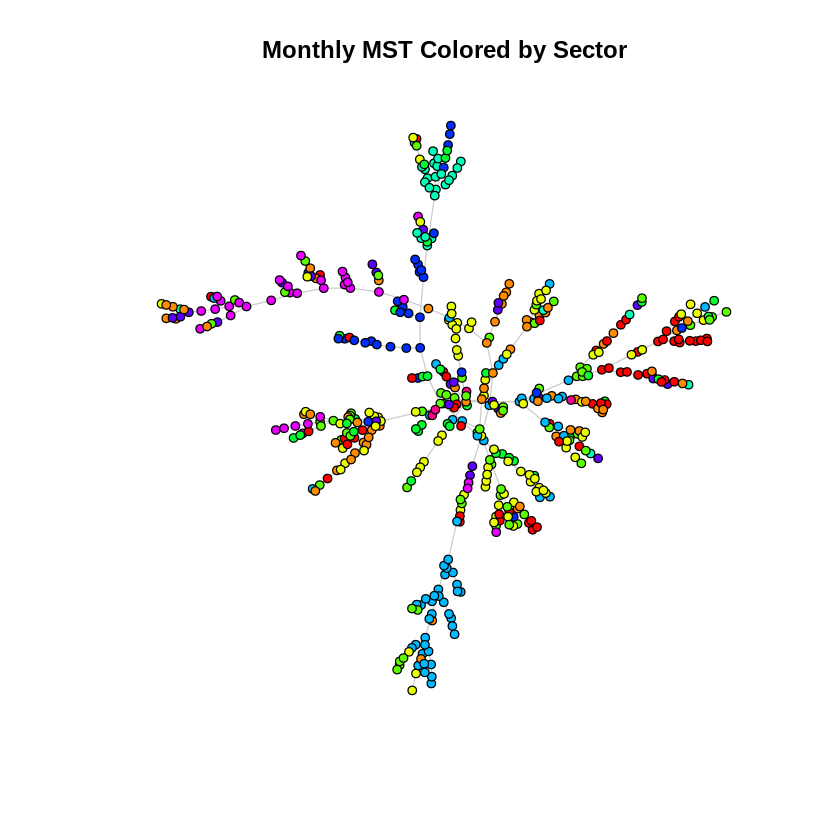

In [14]:
# Q7 - Q3
stock_ids <- rownames(log_norm_mat_month)
vertex_df <- data.frame(name = stock_ids,
                        sector = sector_filtered_month[, 2])

edge_list_month$Source <- as.character(edge_list_month$Source)
edge_list_month$Sink <- as.character(edge_list_month$Sink)

g_month <- graph_from_data_frame(edge_list_month, vertices = vertex_df, directed = FALSE)
E(g_month)$weight <- edge_list_month$Weight

mst_month <- mst(g_month, weights = E(g_month)$weight, algorithm = "prim")

unique_sectors <- unique(vertex_df$sector)
palette <- rainbow(length(unique_sectors))
names(palette) <- unique_sectors

V(mst_month)$color <- palette[V(mst_month)$sector]

layout_mst <- layout_with_fr(mst_month)
plot(mst_month,
     layout = layout_mst,
     vertex.color = V(mst_month)$color,
     vertex.size = 3,
     vertex.label = NA,
     edge.color = "gray80",
     main = "Monthly MST Colored by Sector")


Homogeneity: 0.4794
Completeness: 0.2776


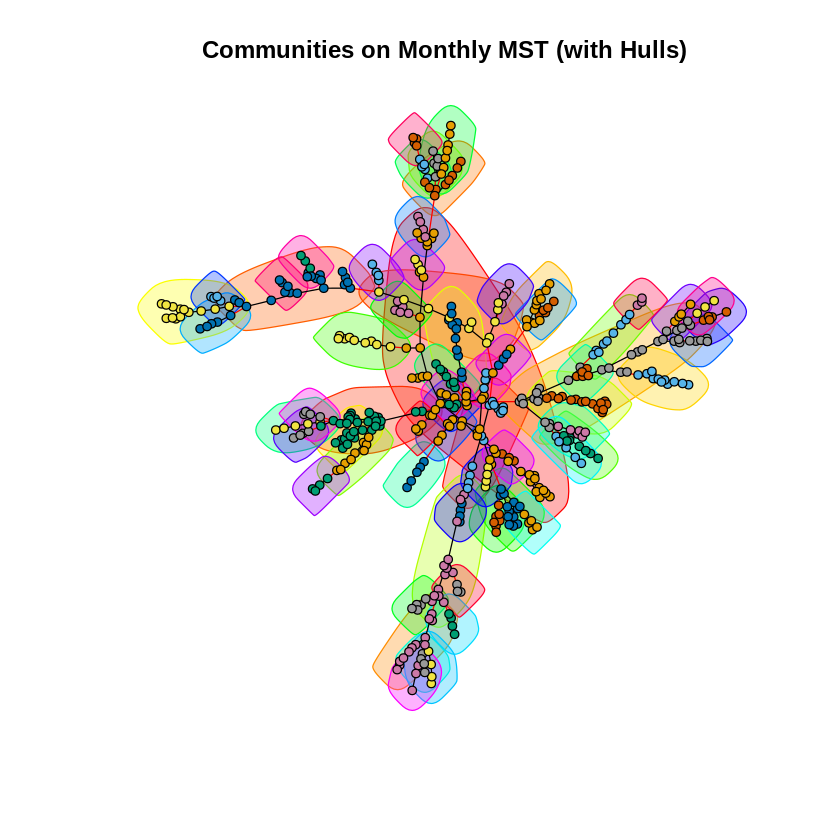

In [15]:
#Q7 - Q4
walktrap_month <- cluster_walktrap(mst_month, weights = E(mst_month)$weight)
membership_month <- membership(walktrap_month)

sector_labels <- V(mst_month)$sector
community_labels <- membership_month

label_df <- data.frame(
  sector = as.factor(sector_labels),
  community = as.factor(community_labels)
)

homogeneity_score <- homogeneity(label_df$sector, label_df$community)
completeness_score <- completeness(label_df$sector, label_df$community)

cat(sprintf("Homogeneity: %.4f\n", homogeneity_score))
cat(sprintf("Completeness: %.4f\n", completeness_score))

plot(
  walktrap_month,
  mst_month,
  layout = layout_mst,
  vertex.label = NA,
  vertex.size = 3,
  vertex.color = V(mst_month)$color,
  main = "Communities on Monthly MST (with Hulls)"
)

In [16]:
# Q7 - Q5
sectors <- V(mst_month)$sector
total_nodes <- vcount(mst_month)
sector_distribution <- table(sectors)

P_same_sector <- numeric(total_nodes)
P_random_baseline <- numeric(total_nodes)

for (v in 1:total_nodes) {
  neighbors_v <- neighbors(mst_month, v)
  if (length(neighbors_v) == 0) {
    P_same_sector[v] <- NA
    P_random_baseline[v] <- NA
    next
  }

  sector_v <- sectors[v]
  same_sector_count <- sum(sectors[neighbors_v] == sector_v)
  P_same_sector[v] <- same_sector_count / length(neighbors_v)

  P_random_baseline[v] <- sector_distribution[sector_v] / total_nodes
}

alpha_month <- mean(P_same_sector, na.rm = TRUE)
baseline_month <- mean(P_random_baseline, na.rm = TRUE)

cat(sprintf("α (neighbor voting accuracy, monthly): %.4f\n", alpha_month))
cat(sprintf("baseline (random guess, monthly):     %.4f\n", baseline_month))


α (neighbor voting accuracy, monthly): 0.4844
baseline (random guess, monthly):     0.1143
